In [1]:
import sqlite3 as sql
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

from category_encoders import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, make_pipeline

warnings.filterwarnings("ignore")

In [21]:
def wrangle(db_path):
    db = "earth_quake_damage.db"
    con = sql.connect(db_path)
    
    query = '''SELECT * FROM NepalEarhquakeDamage2015  WHERE district_id == 24'''
    
    df = pd.read_sql_query(query, con)
    
    df["b_id"] = np.ceil(df["building_id"] / 1e6)
    df = df.set_index("b_id")
    
    df.drop(columns=["building_id", "district_id"], inplace=True)

    df.drop(columns=["count_floors_post_eq", "height_ft_post_eq", "condition_post_eq"], inplace=True)

    df["damage_grade"] = df["damage_grade"].str[-1].astype(int)
    df["severe_damage"] = (df["damage_grade"]>3).astype(int)

    df.drop(columns=["damage_grade"], inplace=True)

    df.drop(columns=["count_floors_pre_eq"], inplace=True)
    
    return df

In [22]:
df = wrangle("earth_quake_damage.db")
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 98019 entries, 240102.0 to 249010.0
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   age_building            98019 non-null  int64 
 1   plinth_area_sq_ft       98019 non-null  int64 
 2   height_ft_pre_eq        98019 non-null  int64 
 3   land_surface_condition  98019 non-null  object
 4   foundation_type         98019 non-null  object
 5   roof_type               98019 non-null  object
 6   ground_floor_type       98019 non-null  object
 7   other_floor_type        98019 non-null  object
 8   position                98019 non-null  object
 9   plan_configuration      98019 non-null  object
 10  severe_damage           98019 non-null  int32 
dtypes: int32(1), int64(3), object(7)
memory usage: 8.6+ MB
None


,age_building,plinth_area_sq_ft,height_ft_pre_eq,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,severe_damage
b_id,,,,,,,,,,,
240102.0,40,324,12,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,Not applicable,Not attached,Rectangular,0
240102.0,30,382,20,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Attached-1 side,Rectangular,1
240102.0,13,405,10,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,Not applicable,Not attached,Rectangular,1
240102.0,25,328,18,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Heavy roof,Mud,Timber-Planck,Not attached,Rectangular,1
240102.0,15,405,20,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,1


In [7]:
df["damage_grade"].value_counts()

Grade 4    28974
Grade 3    25130
Grade 5    23859
Grade 2    11726
Grade 1     8330
Name: damage_grade, dtype: int64

In [8]:
df["damage_grade"] = df["damage_grade"].str[-1].astype(int)

In [9]:
(df["damage_grade"]>3).astype(int)

b_id
240102.0    0
240102.0    1
240102.0    1
240102.0    1
240102.0    1
           ..
249010.0    1
249010.0    0
249010.0    1
249010.0    0
249010.0    0
Name: damage_grade, Length: 98019, dtype: int32

In [14]:
corr = df.select_dtypes("number").drop(columns=["severe_damage"]).corr()
corr

,age_building,plinth_area_sq_ft,height_ft_pre_eq
age_building,1.000000,-0.042042,0.026760
plinth_area_sq_ft,-0.042042,1.000000,0.308231
height_ft_pre_eq,0.026760,0.308231,1.000000


<AxesSubplot:>

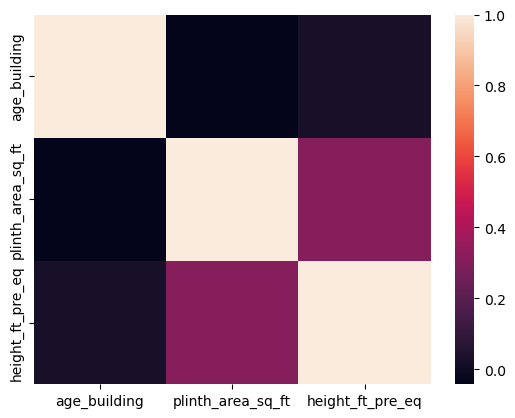

In [15]:
sns.heatmap(corr)

In [20]:
df["severe_damage"].corr(df["count_floors_pre_eq"])

-0.03966095085176501

<AxesSubplot:xlabel='severe_damage', ylabel='height_ft_pre_eq'>

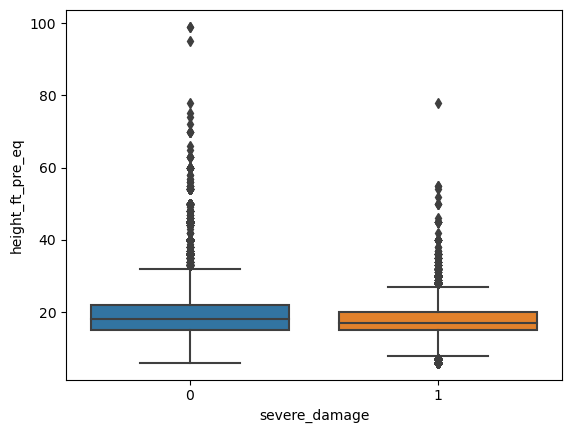

In [23]:
sns.boxplot(x=df["severe_damage"], y=df["height_ft_pre_eq"], data=df)

<AxesSubplot:>

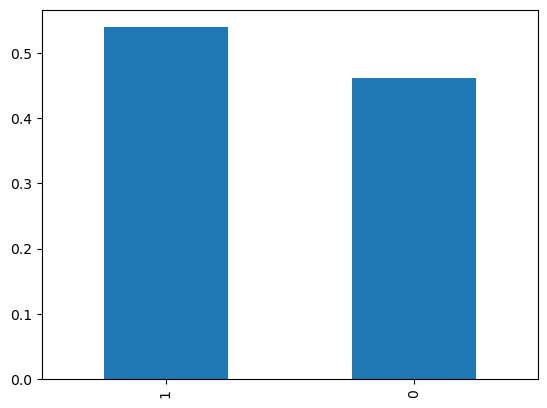

In [24]:
df["severe_damage"].value_counts(normalize=True).plot(kind="bar")

In [9]:
majority_class_prop, minority_class_prop = df["severe_damage"].value_counts(normalize=True)
print(majority_class_prop, minority_class_prop)

0.5390077433966884 0.4609922566033116


In [10]:
foundation_pivot = pd.pivot_table(
    df, index="foundation_type", values="severe_damage", aggfunc=np.mean
).sort_values("severe_damage")
foundation_pivot

,severe_damage
foundation_type,
RC,0.010949
Bamboo/Timber,0.267281
Cement-Stone/Brick,0.272224
Other,0.314741
Mud mortar-Stone/Brick,0.600677


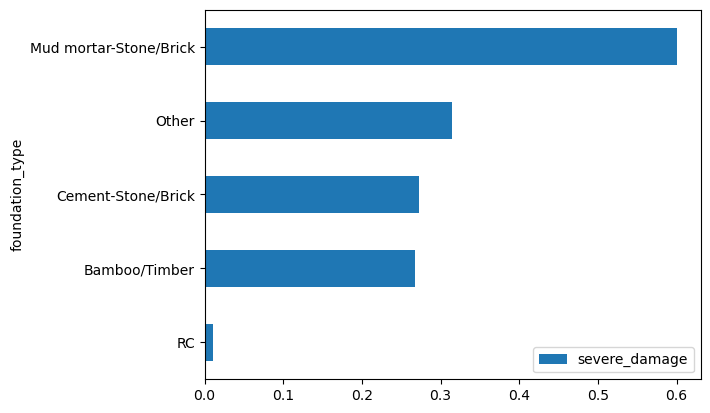

In [11]:
foundation_pivot.plot(kind="barh");

In [12]:
 df.select_dtypes("object").nunique()

land_surface_condition     3
foundation_type            5
roof_type                  3
ground_floor_type          5
other_floor_type           4
position                   4
plan_configuration        10
dtype: int64

In [13]:
target = "severe_damage"

y = df[target]
X = df.drop(columns=[target])

In [14]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 98019 entries, 240102.0 to 249010.0
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   age_building            98019 non-null  int64 
 1   plinth_area_sq_ft       98019 non-null  int64 
 2   height_ft_pre_eq        98019 non-null  int64 
 3   land_surface_condition  98019 non-null  object
 4   foundation_type         98019 non-null  object
 5   roof_type               98019 non-null  object
 6   ground_floor_type       98019 non-null  object
 7   other_floor_type        98019 non-null  object
 8   position                98019 non-null  object
 9   plan_configuration      98019 non-null  object
dtypes: int64(3), object(7)
memory usage: 8.2+ MB


In [15]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(78415, 10)
(78415,)
(19604, 10)
(19604,)


In [16]:
acc_baseline = y_train.value_counts(normalize=True).max()
print("accuracy baseline:", acc_baseline)

accuracy baseline: 0.539871198112606


In [17]:
model = make_pipeline(
    OneHotEncoder(use_cat_names=True),
    LogisticRegression()
).fit(X_train, y_train)

In [18]:
model

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['land_surface_condition',
                                     'foundation_type', 'roof_type',
                                     'ground_floor_type', 'other_floor_type',
                                     'position', 'plan_configuration'],
                               use_cat_names=True)),
                ('logisticregression', LogisticRegression())])

In [19]:
acc_train = accuracy_score(y_train, model.predict(X_train))
acc_test = accuracy_score(y_test, model.predict(X_test))

print("acc train:", acc_train.round(2))
print("acc test:", acc_test.round(2))

acc train: 0.65
acc test: 0.65


In [20]:
model.predict(X_train)[:5]

array([0, 1, 1, 1, 1])

In [21]:
y_train_proba = model.predict_proba(X_train)
y_train_proba[:5]

array([[0.90744489, 0.09255511],
       [0.36454131, 0.63545869],
       [0.39680403, 0.60319597],
       [0.41118522, 0.58881478],
       [0.48994044, 0.51005956]])

In [22]:
coefficient = model.named_steps["logisticregression"].coef_[0]
feature_names = model.named_steps["onehotencoder"].get_feature_names()

In [29]:
odds_ratios = pd.Series(np.exp(coefficient), index=feature_names).sort_values()

In [30]:
odds_ratios[:5]

roof_type_RCC/RB/RBC               0.502310
ground_floor_type_RC               0.505338
foundation_type_RC                 0.589692
other_floor_type_RCC/RB/RBC        0.633087
other_floor_type_Not applicable    0.654254
dtype: float64

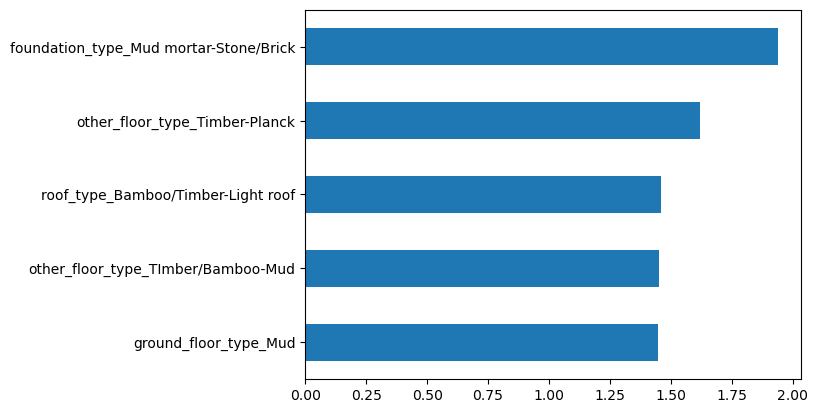

In [26]:
odds_ratios.tail().plot(kind="barh");

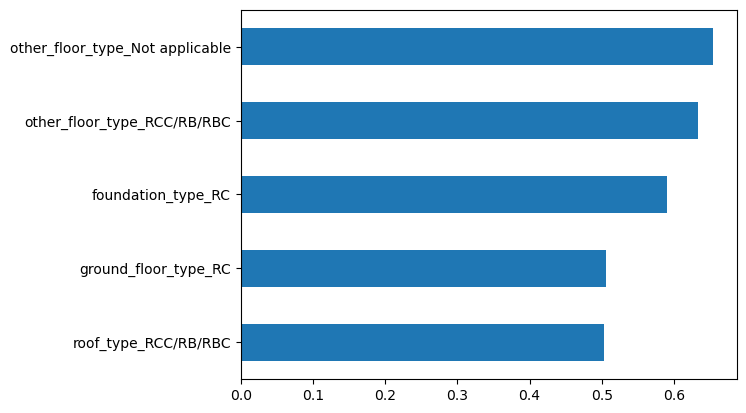

In [31]:
odds_ratios.head().plot(kind="barh");